# Predict Forex candlestick patterns 

The problem:

Check if it is possible to predict forex price movements only based on candlestick data. We will use 1h time-frame data set of EUR/USD during ~2014-2019 year. We will take only 3 last candles and based on that make a prediction of the next candle.

In [1]:
# libraries:

import matplotlib
import numpy as np
import pandas as pd
# import itertools
import sklearn
import keras
import time
# import shap

from keras.models import Sequential
# from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc


print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)

Numpy version: 1.19.5
Pandas version: 1.3.3
Matplotlib version: 3.4.3
Sklearn version: 1.0
Keras version: 2.6.0


/Users/pratik/Library/Python/3.7/lib/python/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [2]:
class MeasureTime:
    def __init__(self):
        self.start = time.time()
    def kill(self):
        print ('Time elapsed: ' + time.strftime("%H:%M:%S", time.gmtime(time.time()-self.start)))
        del self

In [3]:
Notebook_timer = MeasureTime()
Notebook_timer.kill()

Time elapsed: 00:00:00


# 1.1 - Import the dataset
We will download our historical dataset from ducascopy website in form of CSV file, which I have already downloaded. https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed

In [4]:
# Load dataset: (Currently we are using EUR-USD 1-Hour data from Year 2014 to 2021)
my_dataset = pd.read_csv('EURUSD_Candlestick_1_Hour_BID_01.08.2014-09.10.2021.csv')
# deleting columns that are not required for training:
del my_dataset['Local time']
del my_dataset['Volume']
my_dataset.head(5)

,Open,High,Low,Close
0,1.33896,1.33932,1.33873,1.33885
1,1.33887,1.33898,1.33870,1.33893
2,1.33894,1.33902,1.33876,1.33901
3,1.33901,1.33905,1.33875,1.33883
4,1.33882,1.33888,1.33874,1.33879


# Let’s visualize it on the actual OHLC candlestick chart.

In order to do that we need to make our own function that will plot the OHLC data on the chart. We will use matplotlib library with finnance extension called mpl_finance. But before that, we need prepare out dataset to be in 3 dimensional array with format (Timestep, Items, Features)

Timestep = List of candles seqeuence

Items = Candlestick

Features = High, Low, Open, Close parameters

In [5]:
# Function to plot OHLC candlestick data in to chart

def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date=range(len(closep))

    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

/Users/pratik/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


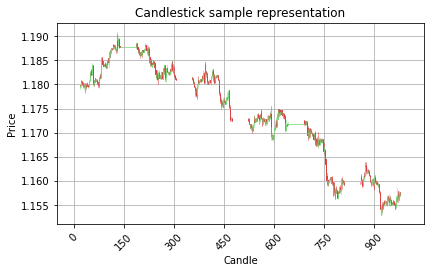

In [6]:
# Visualize 1000 candlesticks on the OHLC chart in one time

graph_data_ohlc(my_dataset.tail(1000).values)

# 1.2 - Converting data to time series format

In order for our machine to learrn from our data, we need to change the format of the data we provide for learning. Most of the human traders do not watch the price but instead, they watch how candlesticks form on the chart and for patterns there. We will look for patterns based on the last 3 candles. To do so, we need to change the format of our dataset to 3 dimensional array (Timestep, Items, Features) .

In [7]:
# Custom generator function to create 3d arrays of candles sequence

def my_generator(data,lookback):
    final_output = []
    counter = 0
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            temp_list.append(candle)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

cell_timer = MeasureTime()
three_dim_sequence = np.asarray(my_generator(my_dataset.values[1:],3))
cell_timer.kill()

print(three_dim_sequence.shape)



Time elapsed: 00:00:29
(63046, 3, 4)


Step 1


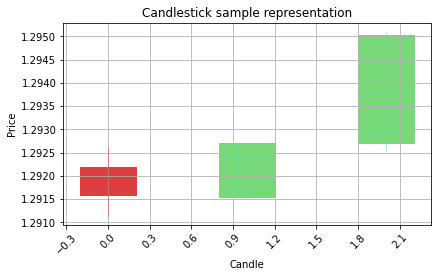

Step 2


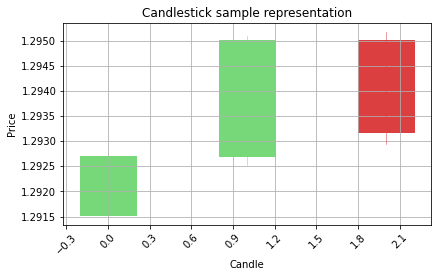

Step 3


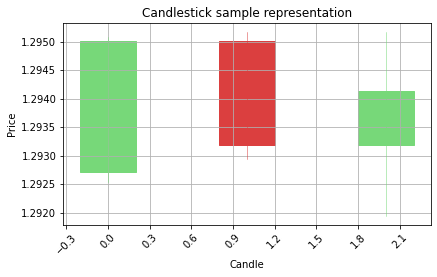

Step 4


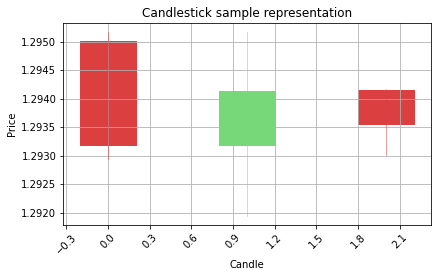

Step 5


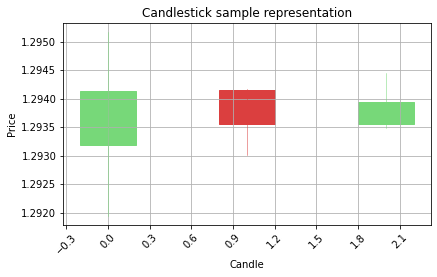

In [8]:
# Now it is time to see how our sequence of 3 candlesticks looks like on the actual chart
# Visualize the step by step sequency of price movements on the OHLC chart

counter=0
for candle in three_dim_sequence[1000:1005]:
    counter=counter+1
    print('Step ' + str(counter))
    graph_data_ohlc(candle)

# 1.3 - Feature engineering

Now it is time to convert the price data in to actual candlestick parameters. Each candle has 4 parameters:

Size of the body measured by pips
Size of the upper wicks measured by pips
Size of the lower wicks measured by pips
Type of the candle (Bullish or Bearish)(Green or Red)(0 or 1)
pip = diffrence between 2 prices multiplied by 10000

In [9]:
# Function to convert OHLC data in to candlestick parameters data

def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[0]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000,2)
    candlestick_data[2]=round(round(wicks_down,5)*10000,2)
    candlestick_data[3]=round(round(body_size,5)*10000,2)

    return candlestick_data

# Lets extract data of only one candle from our dataset of sequences

cell_timer = MeasureTime()
one_candle_data_ohlc=three_dim_sequence[1000:1010][5][1]
cell_timer.kill()

print(one_candle_data_ohlc)

# Convert it to candlestick parameters

one_candle_data_ohlc_candle=ohlc_to_candlestick(one_candle_data_ohlc)

print(one_candle_data_ohlc_candle)

Time elapsed: 00:00:00
[1.29355 1.29445 1.29349 1.29394]
[1, 5.1, 0.6, 3.9]


In [10]:
# Apply this function in to generator function to get sequences with candlestick data instead of OHLC data

def my_generator_candle(data,lookback):
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

# Get the get the data in form of sequences made from last 3 candles

three_dim_sequence_candle=my_generator_candle(my_dataset.values[1:],3)

# Check if conversion applied correctly

print(three_dim_sequence_candle[5000:5005])

[[[ 1.   0.3  2.9  4.2]
  [ 0.   0.8  5.7  0.2]
  [ 0.   0.9  3.8  1.4]]

 [[ 0.   0.8  5.7  0.2]
  [ 0.   0.9  3.8  1.4]
  [ 1.   1.8  3.8  0.3]]

 [[ 0.   0.9  3.8  1.4]
  [ 1.   1.8  3.8  0.3]
  [ 1.   0.3  0.1  5.7]]

 [[ 1.   1.8  3.8  0.3]
  [ 1.   0.3  0.1  5.7]
  [ 1.  15.1  3.8 19.5]]

 [[ 1.   0.3  0.1  5.7]
  [ 1.  15.1  3.8 19.5]
  [ 1.   2.8 16.6  4.7]]]


# Generate forecasting data

Now we have our candlestick values in the correct format for machine to read it and interpret it so, it is time to generete our prediction/forecasting data.

The idea was to predict the next candle type (bullish or bearish) by looking on for the last 3 candles. We got our sequences of 3 candles and now we need to generate another array with one candle information, which we will be forecasting.

In [44]:
# Update of the generator to return one more array with 1 or 0 (Bullish or Bearish)

def my_generator_candle_X_Y(data,lookback,MinMax = False):
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    first_row = 0
    arr = np.empty((0,lookback,4))
    arr3 = np.empty((0,lookback,4))
    Y_list = []
    for a in range(len(data)-lookback):
        temp_list = []
        temp_list_raw = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
            temp_list_raw.append(candle)
        temp_list3 = [np.asarray(temp_list)]
        templist4 = np.asarray(temp_list3)

        if MinMax==True:
            templist99 = scaler.fit_transform(templist4[0])
            arr = np.append(arr, [templist99], axis=0)
        else:
            arr = np.append(arr, templist4, axis=0)

        temp_list7 = [np.asarray(temp_list_raw)]
        templist8 = np.asarray(temp_list7)
        arr3 = np.append(arr3, templist8, axis=0)
        print("data: ", data[first_row+lookback])
        converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])
        Prediction = converted_data_prediction[0]
        print("y pred: ", Prediction)
        Y_list.append(Prediction)

        first_row=first_row+1

    arr2 = np.asarray(Y_list)
    print("X: ", arr)
    print("Y: ", arr2)
    print("X_raw: ", arr3)
    return arr,arr2,arr3

# We will call the function and receive 2 datasets:
# X = Input dataset on which our neural network will make predictions
# Y = Prediction dataset (results of the correct predictions)
cell_timer = MeasureTime()
X,Y, X_raw = my_generator_candle_X_Y(my_dataset[0:5].values,3,MinMax=False)
cell_timer.kill()
print('Shape of X ' + str(X.shape))
print('Shape of Y ' + str(Y.shape))
print('Shape of X raw ohlc ' + str(X_raw.shape))

data:  [1.33901 1.33905 1.33875 1.33883]
y pred:  0
data:  [1.33882 1.33888 1.33874 1.33879]
y pred:  0
X:  [[[0.  3.6 1.2 1.1]
  [1.  0.5 1.7 0.6]
  [1.  0.1 1.8 0.7]]

 [[1.  0.5 1.7 0.6]
  [1.  0.1 1.8 0.7]
  [0.  0.4 0.8 1.8]]]
Y:  [0 0]
X_raw:  [[[1.33896 1.33932 1.33873 1.33885]
  [1.33887 1.33898 1.3387  1.33893]
  [1.33894 1.33902 1.33876 1.33901]]

 [[1.33887 1.33898 1.3387  1.33893]
  [1.33894 1.33902 1.33876 1.33901]
  [1.33901 1.33905 1.33875 1.33883]]]
Time elapsed: 00:00:00
Shape of X (2, 3, 4)
Shape of Y (2,)
Shape of X raw ohlc (2, 3, 4)


In [40]:
X[0:10]
y_pred = [1,0,0,1,1,0,0,1,1,0]
Y[0:10]

array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0])

In [12]:
# How many bullish and bearish predictions?

unique, counts = np.unique(Y, return_counts=True)
predictions_type = dict(zip(unique, counts))
print('Bull: ' + str((predictions_type[1])) + ' percent: ' + str(round((predictions_type[1]*100)/len(Y),2)) + '%')
print('Bear: ' + str((predictions_type[0])) + ' percent: ' + str(round((predictions_type[0]*100)/len(Y),2)) + '%')
print('Total: ' + str(len(Y)))

Bull: 22408 percent: 35.54%
Bear: 40638 percent: 64.46%
Total: 63046


Correct prediction would be Bearish ---v


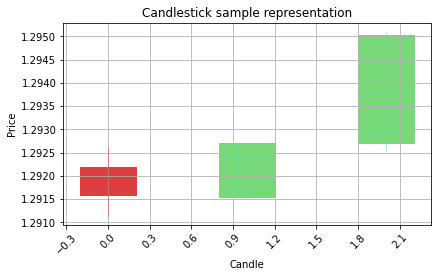

Correct prediction would be Bullish ---^


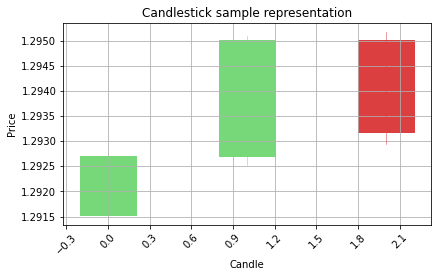

Correct prediction would be Bearish ---v


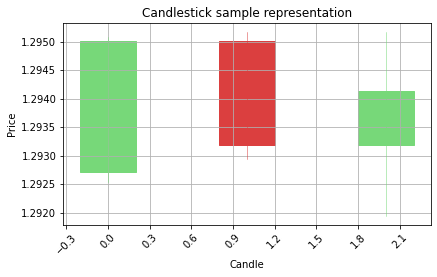

Correct prediction would be Bullish ---^


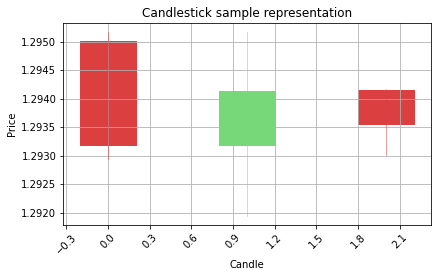

Correct prediction would be Bearish ---v


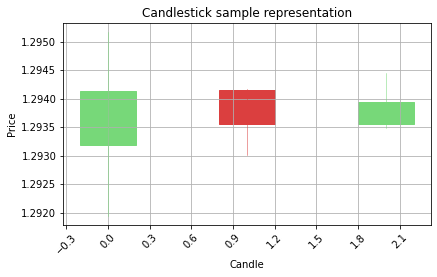

In [13]:
# Now we know that our data for predictions is distributed equally.
# Visualize the candle sequence:

for a in range(5):
    b=a+1000
    if Y[b] == 1:print('Correct prediction would be Bullish ---^')
    if Y[b] == 0:print('Correct prediction would be Bearish ---v')
    graph_data_ohlc(X_raw[b])

# 1.4 - Build Deep Learning model

For all sequence dataset the best model are RNN - Recurrent neural network. For our case we will build the LSTM network ( Long-Term Short-Term)

The basics, for all the training and prediction will be responsible the tensorflow library, with high level API called KERAS.

In [27]:
# Defining the model

from keras import layers
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dropout
model = Sequential()
model.add(layers.LSTM(units = 12,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(Dropout(0.3))
model.add(layers.LSTM(units = 24))
model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# The model is build from 2 LSTM layers with 12,24 units(so called neurons). 
# More layers and more units we add, more details our model will catch. But there is also a risk, 
# if we add more “space” for model to learn, the model can quickly overfit the trainig data.

# Definition of the compiled model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 12)          816       
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 12)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                3552      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 4,393
Trainable params: 4,393
Non-trainable params: 0
_________________________________________________________________


# In order train the deep learning model we need to split our data for 3 parts:

## Traning dataset
## Validation dataset
## Test dataset

In [28]:
cell_timer = MeasureTime()
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

X_train_raw, X_val_and_test_raw= train_test_split(X_raw, test_size=0.5)
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.5)
cell_timer.kill()

print('Training data: ' + 'X Input shape: ' + str(X_train.shape) + ', ' + 'Y Output shape: ' + str(Y_train.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))
print('Validation data: ' + 'X Input shape: ' + str(X_val.shape) + ', ' + 'Y Output shape: ' + str(Y_val.shape) + ', ' + 'datetime shape: ' + str(Y_val.shape))
print('Test data: ' + 'X Input shape: ' + str(X_test.shape) + ', ' + 'Y Output shape: ' + str(Y_test.shape) + ', ' + 'datetime shape: ' + str(Y_test.shape))

Time elapsed: 00:00:00
Training data: X Input shape: (31523, 3, 4), Y Output shape: (31523,), datetime shape: (31523,)
Validation data: X Input shape: (15761, 3, 4), Y Output shape: (15761,), datetime shape: (15761,)
Test data: X Input shape: (15762, 3, 4), Y Output shape: (15762,), datetime shape: (15762,)


# Train the Neural Network model and save trainig outputs ‘history’ variable

We will train the model 13 times and uploud batches with 500 items from our training dataset for one training iteration.

In [29]:
cell_timer = MeasureTime()
history = model.fit(X_train, Y_train,batch_size=500, epochs=25,validation_data=(X_val, Y_val))
cell_timer.kill()

Epoch 1/25
64/64 [==============================] - 4s 18ms/step - loss: 0.6584 - acc: 0.6445 - val_loss: 0.6092 - val_acc: 0.6485
Epoch 2/25
64/64 [==============================] - 1s 9ms/step - loss: 0.5667 - acc: 0.6383 - val_loss: 0.5363 - val_acc: 0.6496
Epoch 3/25
64/64 [==============================] - 1s 9ms/step - loss: 0.5331 - acc: 0.6399 - val_loss: 0.5277 - val_acc: 0.6378
Epoch 4/25
64/64 [==============================] - 1s 9ms/step - loss: 0.5269 - acc: 0.6382 - val_loss: 0.5254 - val_acc: 0.6360
Epoch 5/25
64/64 [==============================] - 1s 9ms/step - loss: 0.5245 - acc: 0.6419 - val_loss: 0.5225 - val_acc: 0.6462
Epoch 6/25
64/64 [==============================] - 1s 9ms/step - loss: 0.5215 - acc: 0.6410 - val_loss: 0.5219 - val_acc: 0.6344
Epoch 7/25
64/64 [==============================] - 1s 9ms/step - loss: 0.5190 - acc: 0.6490 - val_loss: 0.5189 - val_acc: 0.6452
Epoch 8/25
64/64 [==============================] - 1s 11ms/step - loss: 0.5181 - acc: 0.

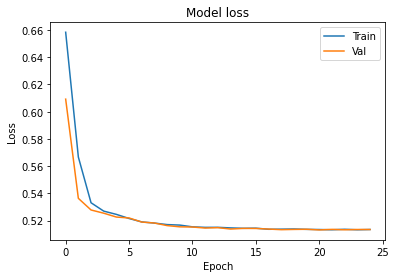

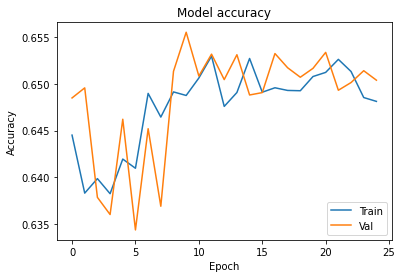

In [30]:
# Plot the charts to see model training loss and validation loss

# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [31]:
# 1.5 - Test the model against new data

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy: ' + str(np.round(test_acc*100,2)) + " %")

493/493 [==============================] - 1s 2ms/step - loss: 0.5116 - acc: 0.6530
Test accuracy: 65.3 %


# Visualize the predictions on the candlestick charts to see the patterns

Below there is a function to filter out the low confidence predictions from the model by using the alpha distance variable. If the prediction value is close to 0, that means the prediction is 0, the same case with prediction 1, if the predicted value is closer to 1 instead of 0, it means the model predicted the value 1. If the prediction value is closer to its target, that means the confidence of the prediction is bigger. Less distance to the target prediction value, better the confidence. Please make sure that this approach works only with binary classification problems

In [33]:
cell_timer = MeasureTime()
counter = 0
won = 0
lost = 0
# predictions for testing data:
test = model.predict(X_test)

# This is the filter for ignoring less confident predictions, you can change according to your wish: 
# (0.35 means 1-0.3 i.e. 0.70 or 70% or more confident predictions are to be considered,rest discarded)
alpha_distance = 0.3
# print(test.shape)
# Checking accuracy on 1st 200 test data and alpha distance 0.35 
# (means we only consider predictions with more than 65% of conviction/probability) 
# and due to which a lot of predictions will get filtered:
for a in test[0:5099]:
    #print(a)
    if a > (1-alpha_distance) or a < alpha_distance :
        print(a)
        # if Y_test[counter] == 1:print('Correct prediction is Bullish')
        # if Y_test[counter] == 0:print('Correct prediction is Bearish')
        # if a > (1-alpha_distance):print('Model prediction is Bullish with a confidence of ' + str(np.round((1-a[0])*100,2)) + '%')
        # if a < alpha_distance:print('Model prediction is Bearish with a confidence of ' + str(np.round((1-a[0])*100,2)) + '%')

        if (a > (1-alpha_distance) and Y_test[counter] == 1) or (a < alpha_distance and Y_test[counter] == 0):
            won=won+1
            # print('WON')
        else:
            print('LOST')
            lost=lost+1
        # graph_data_ohlc(X_test_raw[counter])

    counter=counter+1
print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')
cell_timer.kill()


[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
LOST
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.00252718]
[0.0109539]
[0.01095387]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.01095387]
[0.0109539]
LOST
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.01095387]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.01095387]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.03668246]
[0.01095387]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]
[0.0109539]

# Looks like we manage the get awesome results with our model after manipulating the alpha_distance value.

Won: 50 Lost: 2
Success rate approx.: 96%
Thats huge!

In [ ]:
# Updating forecasting in google sheets:
import gspread

sa = gspread.service_account()
sh = sa.open("FX - AI/ML Model Sheet")
wks = sh.worksheet("Sheet")
wks.update('M10', str(round((won*100)/(won+lost),2)) + '%')